# Adiabatic Tests

In [1]:
import rebound
import airball
import numpy as np
import astropy.units as u

import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.style as style
style.use('tableau-colorblind10')

#### Define constants and parameters
We also define some useful constants and parameters for setting up our system. We take the current values of Neptune's orbital elements but will first consider the planar case. Additionally, we pick a set of parameters for our stellar flyby as a specific example.

In [2]:
pi = np.pi
twopi = 2.*pi

sun_mass = 1.0 * u.solMass # Msun

# Basic orbital elements of Neptune
planet_mass = 5.151383772628674e-05 * u.solMass
planet_a = 30.27762143269065 * u.au
planet_e = 0.012971767987242259 * u.dimensionless_unscaled
# More if you don't want Neptune to be planar.
planet_inc = 0.030870657846206642 * u.rad
planet_omega = 4.337864438269479 * u.rad
planet_Omega = 2.2992717711122466 * u.rad

# Set the orbital elements of the flyby star
# Simulate a randomly oriented, 1 solar mass stellar flyby with relative velocity of 5 km/s, and an impact parameter of 100 AU.
star = airball.Star(m = 1 * u.solMass, b = 125 * u.au, v = 5 * u.km/u.s, inc = 1.12 * u.rad, omega = 1.09 * u.rad, Omega = 0.97 * u.rad)
print('star.inc:   {0:7.2f}'.format(star.inc.to(u.deg)))
print('star.omega: {0:7.2f}'.format(star.omega.to(u.deg)))
print('star.Omega: {0:7.2f}'.format(star.Omega.to(u.deg)))

star.inc:     64.17 deg
star.omega:   62.45 deg
star.Omega:   55.58 deg


#### Setup a two-body simulation and run a flyby simulation.
We define a function that returns a consistent `REBOUND` Simulation setup for convenience and reproducibility.

In [3]:
def setup(planet_mass=5.151383772628674e-05*u.solMass, planet_a=30.27762143269065*u.au, planet_e=0.012971767987242259 * u.dimensionless_unscaled, planet_inc=0*u.rad, planet_omega=0*u.rad, planet_Omega=0*u.rad, planet_f=0*u.rad):
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=sun_mass.value)
    sim.add(m=planet_mass.value, a=planet_a.value, e=planet_e.value, inc=planet_inc.value, omega=planet_omega.value, Omega=planet_Omega.value, f=planet_f.value)
    
    sim.integrator = 'whckl'
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.01 * sim.particles[1].P
    sim.move_to_com()
    return sim

## Implementation Details

We found that  when probing changes to a system from an adiabatic flyby (when the velocity of the incoming star is much less than the velocity of the planets) it is important to begin with the star around $4\cdot 10^5\,\mathrm{AU}$ away from the Sun, see [Adiabatic](./Adiabatic.ipynb) for more details.

### Investigate the effects from a flyby with respect to impact parameter.

The effects of a stellar flyby on star-planet energy depends exponentially on the perihelion distance. There is a power-law dependence on the effect of a stellar flyby on the eccentricity of a star-planet system. We can investigate this by running a couple hundred flyby scenarios while systematically changing the perihelion distance. If each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters.

The following takes about 90 seconds to run on an M1 Macbook Air.

In [6]:
ma = airball.tools.moving_average

In [7]:
Nflybys = 500
energy = np.zeros(Nflybys+1)
e = np.zeros(Nflybys+1)
analytic_dE = np.zeros(Nflybys)
analytic_de = np.zeros(Nflybys)
est_dE = np.zeros(Nflybys)
est_de = np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)

sim = setup()
energy[0] = sim.energy()
orb = sim.calculate_orbits()
e[0] = orb[0].e

star_bs = np.logspace(0, 4, Nflybys) * planet_a
stars = airball.Stars(m=star.m, b=star_bs, v=star.v)

sims = [setup() for i in range(Nflybys)]
sim_results = airball.flybys(sims, stars=stars)

for i in range(Nflybys):
    analytic_dE[i] = np.abs(airball.relative_energy_change(sims[i], stars[i]))
    analytic_de[i] = np.abs(airball.eccentricity_change_adiabatic_estimate(sims[i], stars[i])/e[0])
    est_dE[i] = np.abs(airball.relative_energy_change(sims[i], stars[i], averaged=True))
    est_de[i] = np.abs(airball.eccentricity_change_adiabatic_estimate(sims[i], stars[i], averaged=True)/e[0])
    
    energy[i+1] = sim_results[i].energy()
    nsteps[i] = sim_results[i].steps_done
    orb = sim_results[i].calculate_orbits()
    e[i+1] = orb[0].e

dE = np.abs((energy[1:]-energy[0])/energy[0])
de = np.abs((e[1:]-e[0])/e[0])

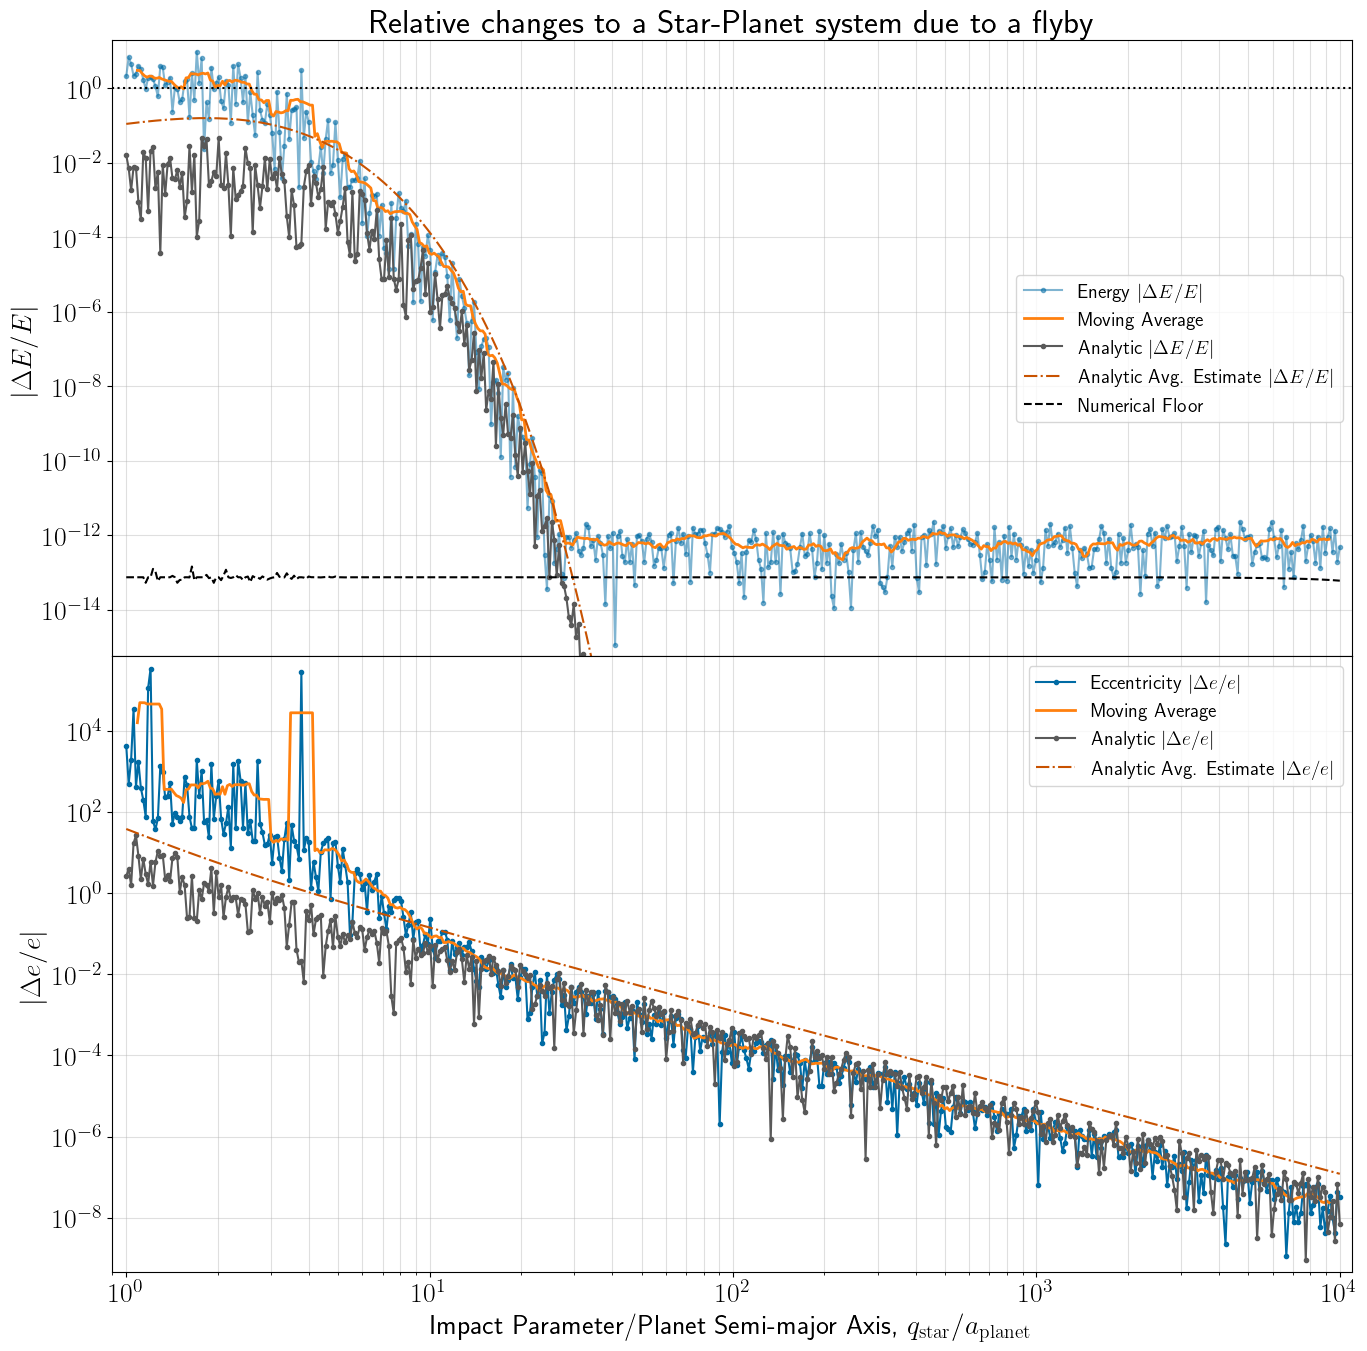

In [8]:
b_a = star_bs/planet_a

plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(2,1, figsize=(16,16), sharex=True)
ax[0].set_title('Relative changes to a Star-Planet system due to a flyby')

ax[0].plot(b_a, dE, 'C0.-', alpha=0.5, label=r'Energy $|\Delta E/E|$')
ax[0].plot(ma(b_a, n=10), ma(dE, n=10), 'C1-', lw=2, label='Moving Average')
ax[0].plot(b_a, analytic_dE, 'C3.-', label=r'Analytic $|\Delta E/E|$')
ax[0].plot(b_a, est_dE, 'C5-.', label=r'Analytic Avg. Estimate $|\Delta E/E|$')
ax[0].plot(b_a, 2.0**(-53.0) * np.sqrt(nsteps), 'k--', label='Numerical Floor')
ax[0].axhline(y=1, ls=':', c='k')
ax[0].legend(prop={'size': 14})
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].xaxis.grid(True, which='both', alpha=0.4)
ax[0].yaxis.grid(True, which='both', alpha=0.4)
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(b_a)*0.9, np.max(b_a)*1.1])
ax[0].set_ylim([np.min(dE)/2, np.max(dE)*2])

ax[1].plot(b_a, de, 'C0.-', label=r'Eccentricity $|\Delta e/e|$')
ax[1].plot(ma(b_a, n=10), ma(de, n=10), 'C1-', lw=2, label='Moving Average')
ax[1].plot(b_a, analytic_de, 'C3.-', label=r'Analytic $|\Delta e/e|$')
ax[1].plot(b_a, est_de, 'C5-.', label=r'Analytic Avg. Estimate $|\Delta e/e|$')
ax[1].legend(prop={'size': 14})
ax[1].set_ylim([np.min([de,analytic_de])/2, np.max([de,analytic_de])*2])
ax[1].set_yscale('log')
ax[1].xaxis.grid(True, which='both', alpha=0.4)
ax[1].yaxis.grid(True, which='both', alpha=0.4)
ax[1].set_ylabel(r'$|\Delta e/e|$')
ax[1].set_xlabel(r'Impact Parameter/Planet Semi-major Axis, $q_\mathrm{star}/a_\mathrm{planet}$')

plt.subplots_adjust(hspace=0.)
plt.show()

We can see that when $q_\mathrm{star}/a_\mathrm{planet} < 10$ the adiabatic analytical estimate begins to diverge from the numerical value given by `airball` and `rebound`.

### Investigate the effects from a flyby with respect to velocity.

The effects of a stellar flyby on a star-planet depends exponentially on the perihelion distance. We can investigate this by running a couple hundred flyby scenarios while systematically changing the perihelion distance. If each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters.

The following takes about 5 minutes to run on an M1 Macbook Air.

In [9]:
Nflybys = 500
energy = np.zeros(Nflybys+1)
e = np.zeros(Nflybys+1)
analytic_dE = np.zeros(Nflybys)
analytic_de = np.zeros(Nflybys)
est_dE = np.zeros(Nflybys)
est_de = np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)

sim = setup()
planet_v = (sim.particles[1].v * u.au/airball.yr2pi).to(u.km/u.s) # planet's orbital velocity in km/s

energy[0] = sim.energy()
orb = sim.calculate_orbits()
e[0] = orb[0].e

star_vs = np.logspace(np.log10(planet_v.value * 1e-2), np.log10(planet_v.value * 1e3), Nflybys)

sims = [setup() for i in range(Nflybys)]
stars = airball.Stars(m=star.m, b=20 * planet_a, v=star_vs)

sim_results = airball.flybys(sims, stars)

for i in range(Nflybys):
    analytic_dE[i] = np.abs(airball.relative_energy_change(sims[i], stars[i]))
    analytic_de[i] = np.abs(airball.eccentricity_change_adiabatic_estimate(sims[i], stars[i])/planet_e)
    est_dE[i] = np.abs(airball.relative_energy_change(sims[i], stars[i], averaged=True))
    est_de[i] = np.abs(airball.eccentricity_change_adiabatic_estimate(sims[i], stars[i], averaged=True)/planet_e)
    
    energy[i+1] = sim_results[i].energy()
    nsteps[i] = sim_results[i].steps_done
    orb = sim_results[i].calculate_orbits()
    e[i+1] = orb[0].e

dE = np.abs((energy[1:]-energy[0])/energy[0])
de = np.abs((e[1:]-e[0])/e[0])

/Users/zyrxvo/.venvs/starlight/lib/python3.10/site-packages/rebound/simulation.py:1032: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


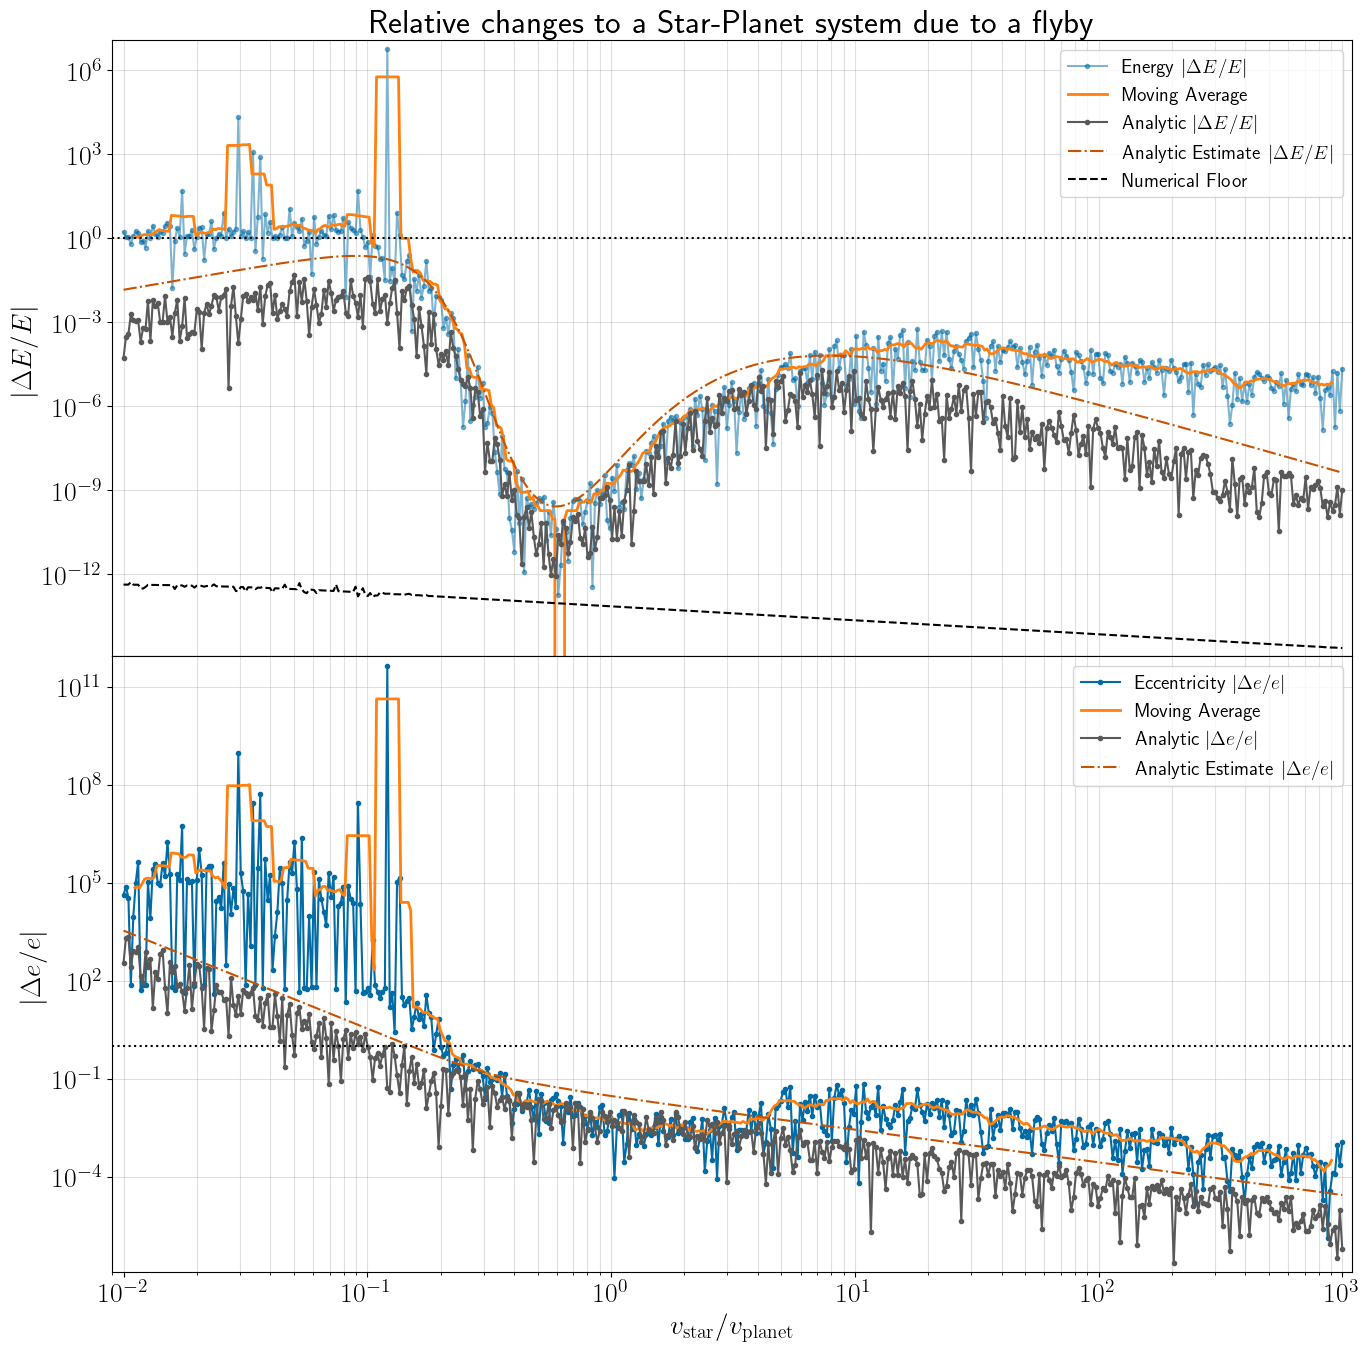

In [10]:
vs_v = star_vs/planet_v.value
floor = 2.0**(-53.0) * np.sqrt(nsteps)

plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(2,1, figsize=(16,16), sharex=True)
ax[0].set_title('Relative changes to a Star-Planet system due to a flyby')

ax[0].plot(vs_v, dE, 'C0.-', alpha=0.5, label=r'Energy $|\Delta E/E|$')
ax[0].plot(ma(vs_v, n=10), ma(dE, n=10), 'C1-', lw=2, label='Moving Average')
ax[0].plot(vs_v, analytic_dE, 'C3.-', label=r'Analytic $|\Delta E/E|$')
ax[0].plot(vs_v, est_dE, 'C5-.', label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].plot(vs_v, floor, 'k--', label='Numerical Floor')
ax[0].axhline(y=1, ls=':', c='k')
ax[0].legend(prop={'size': 14})
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].xaxis.grid(True, which='both', alpha=0.4)
ax[0].yaxis.grid(True, which='both', alpha=0.4)
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(vs_v)*0.9, np.max(vs_v)*1.1])
ax[0].set_ylim([np.min([dE, floor])/2, np.max(dE)*2])

ax[1].plot(vs_v, de, 'C0.-', label=r'Eccentricity $|\Delta e/e|$')
ax[1].plot(ma(vs_v, n=10), ma(de, n=10), 'C1-', lw=2, label='Moving Average')
ax[1].plot(vs_v, analytic_de, 'C3.-', label=r'Analytic $|\Delta e/e|$')
ax[1].plot(vs_v, est_de, 'C5-.', label=r'Analytic Estimate $|\Delta e/e|$')
ax[1].axhline(y=1, ls=':', c='k')
ax[1].legend(prop={'size': 14})
ax[1].set_ylim([np.min([de,analytic_de])/2, np.max([de,analytic_de])*2])
ax[1].set_yscale('log')
ax[1].xaxis.grid(True, which='both', alpha=0.4)
ax[1].yaxis.grid(True, which='both', alpha=0.4)
ax[1].set_ylabel(r'$|\Delta e/e|$')
ax[1].set_xlabel(r'$v_\mathrm{star}/v_\mathrm{planet}$')

plt.subplots_adjust(hspace=0.)
plt.show()